In [119]:
import plotly.express as px
import pandas as pd
import numpy as np
import fairlearn
np.__version__, fairlearn.__version__
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.utils import resample
import tensorflow as tf

# In-processing
from aif360.datasets import StandardDataset


# M√©triques
from aif360.sklearn.metrics import *
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# Introduction NIH Chest X-Rays

Ce dataset vient de : 
https://www.kaggle.com/datasets/nih-chest-xrays/data

C'est un dataset qui contient des donn√©es sur des images X-Rays et leurs patients,

Les radiographies thoraciques font partie des examens d'imagerie m√©dicale les plus fr√©quents et les plus rentables. Cependant, le diagnostic clinique √† partir d'une radiographie thoracique peut √™tre complexe. 
L'absence de grands ensembles de donn√©es publics avec des annotations rend encore tr√®s difficile, l'obtention de syst√®mes de d√©tection et de diagnostic assist√©s par ordinateur cliniquement pertinents.

Le but de se projet serait donc d'entrainer un modele pour reconnaitre les maladies presentes dans les radiographies du dataset.

les colonnes plus pertinentes sont:
 - Finding Labels : 15 labels, 14 indiquant des maladies et 1 indiquant l'absence des maladies
 - Follow-up # : le nombre de fois que ce patient revient faire des X-rays
 - Patient Age
 - Patient Gender 
 - View Position : Position dans laquelle l'image a √©t√© prise

Le reste des donn√©es (sauf le Patient ID seront effac√©s car on considere qu'elles ne sont pas pertinents).

Dans le contexte de ce Projet on analysera uniquement 55174 lignes de ce dataset, et on traitera principalement l'analyse prealabl√© de ces donn√©es et des techniques de pre-processing pour reduire les biais possibles.

In [42]:
mydata = pd.read_csv('LEIVA_MARTIN/metadata.csv')

#On enleve des metadonn√©es des images qui ne sint pas utiles
mydata= mydata.drop(columns=[
                             'OriginalImage[Width','Height]',
                             'OriginalImagePixelSpacing[x','y]',
                             ])

#On voit des lignes avec des gens ayant plus de 120 ans , meme 414 ans!
#On a decid√© de les eliminer
mydata = mydata[mydata['Patient Age'] <= 115]

#Ici on cherche a separer les maladies par colonne
conditions_encoded = mydata['Finding Labels'].str.get_dummies(sep='|')
mydata = mydata.drop(columns=['Finding Labels'])
mydata = pd.concat([mydata, conditions_encoded], axis=1)
mydata['Patient Gender'] = mydata['Patient Gender'].map({'M': 0, 'F': 1})
mydata['View Position'] = mydata['View Position'].map({'PA': 0, 'AP': 1})


In [43]:

maladies = conditions_encoded.columns

maladie_counts = [mydata[maladie].sum() for maladie in maladies]

maladies_with_counts = {}

i = 0
for maladie in maladies:
    maladies_with_counts[maladie] = maladie_counts[i]
    i += 1


# Creation des subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=["Follow Up", "Age", "Gender", "View Position"])

# On ajoute 4 Subplots
fig.add_trace(go.Box(x=mydata['Follow-up #'], name='Follow ups'), row=1, col=1)
fig.add_trace(go.Box(x=mydata['Patient Age'], name='Age'), row=1, col=2)
fig.add_trace(go.Histogram(x=mydata['Patient Gender'], name='Gender'), row=2, col=1)
fig.add_trace(go.Histogram(x=mydata['View Position'], name='View Position'), row=2, col=2)

#Barplot sur les images par maladie
fig2 = go.Figure(
    data = [go.Bar ( x = maladies, y = maladie_counts, text = maladie_counts, textposition='auto' )],
    layout_title_text = "Nombre de radiographies par maladie",
)


fig.update_layout(title="Plots des donn√©es")
fig.show()
fig2.show()

# Analyse des donn√©es

## Follow-up :

On remarque une quantit√© assez grande d'outliers :

    Q1 : 0
    M√©diane : 3
    Q3 : 10

## √Çge :
 
L'individu le plus jeune a 1 an et le plus √¢g√© a 95 ans.
Nous avons d√©cid√© de limiter l'√¢ge √† 115 ans (le record mondial), car nous avons trouv√© un individu √¢g√© de plus de 400 ans.

    Q1 : 34
    M√©diane : 49
    Q3 : 60

## Genre :

On remarque que les genres ne sont pas d√©s√©quilibr√©s de fa√ßon significative ; cependant, les hommes sont majoritaires.
Position de vue :

On remarque qu'il y a une diff√©rence d‚Äôenviron 10 000 images entre les positions PA et AP :

    AP : Avant vers arri√®re
    PA : Arri√®re vers avant

## Maladies :

En ce qui concerne les maladies, c'est l'aspect o√π l'on observe le plus de d√©s√©quilibre.

Notamment, on remarque que No Finding est √©norm√©ment sur-repr√©sent√© avec environ 29 000 occurrences, tandis que Hernia et Pneumonia sont sous-repr√©sent√©s avec respectivement 126 et 718 occurrences.

Afin de mieux visualiser les √©carts entre les maladies et les autres donn√©es, nous allons raisonner en pourcentages.

In [44]:
from IPython.display import Markdown, display
import numpy as np

heading = "#####"
md_output = "# Difference par rapport √† la moyenne:\n"


# Calculer la proportion de chaque maladie
moyenne_par_maladie = [mydata[maladie].mean() for maladie in maladies]

# Calculer la moyenne des proportions
overall_average = np.mean(moyenne_par_maladie)

# Calculer l'√©cart type pour chaque maladie
ecarts_types = [mydata[maladie].std() for maladie in maladies]

# Ajouter les diff√©rences par rapport √† la moyenne
for i, maladie in enumerate(maladies):
    difference = (moyenne_par_maladie[i] - overall_average) * 100
    md_output += f"{heading} - **{maladie}**: {difference:.2f}% (√âcart type: {ecarts_types[i]:.4f})\n"

# Ajouter les autres pourcentages
md_output += "\n# Autres pourcentages:\n"
md_output += f"- Pourcentage d'images etant des **Femmes**: {sum((mydata['Patient Gender'] == 'F')/len(mydata))*100 : .2f}%\n"
md_output += f"- Pourcentage d'images etant des **Hommes**: {sum((mydata['Patient Gender'] == 'M')/len(mydata))*100 : .2f}%\n"
md_output += f"- Pourcentage d'images en vue **PA**: {sum((mydata['View Position'] == 'PA')/len(mydata))*100 : .2f}%\n"
md_output += f"- Pourcentage d'images en vue **AP**: {sum((mydata['View Position'] == 'AP')/len(mydata))*100 : .2f}%\n"

# Afficher le r√©sultat en Markdown

md_output += ''' \n On confirme bien ce qu'on voit dans le graphique. Les conditions sont severement desequibr√©s, Notamment No Findings qui est 45% plus presente que la moyenne,
l 'ecart type est utile pour comprendre la distribution des maladies et pour identifier celles qui ont des occurrences plus pr√©visibles ou plus variables.
Des √©carts types faibles sugg√®rent que la maladie est pr√©sente de mani√®re relativement constante parmi les patients'''
display(Markdown(md_output))

# Difference par rapport √† la moyenne:
##### - **Atelectasis**: 1.82% (√âcart type: 0.3050)
##### - **Cardiomegaly**: -5.87% (√âcart type: 0.1618)
##### - **Consolidation**: -4.38% (√âcart type: 0.2001)
##### - **Edema**: -6.40% (√âcart type: 0.1453)
##### - **Effusion**: 5.05% (√âcart type: 0.3428)
##### - **Emphysema**: -6.00% (√âcart type: 0.1577)
##### - **Fibrosis**: -7.10% (√âcart type: 0.1198)
##### - **Hernia**: -8.47% (√âcart type: 0.0293)
##### - **Infiltration**: 9.26% (√âcart type: 0.3827)
##### - **Mass**: -2.90% (√âcart type: 0.2310)
##### - **No Finding**: 43.26% (√âcart type: 0.4997)
##### - **Nodule**: -1.84% (√âcart type: 0.2503)
##### - **Pleural_Thickening**: -5.51% (√âcart type: 0.1719)
##### - **Pneumonia**: -7.32% (√âcart type: 0.1104)
##### - **Pneumothorax**: -3.61% (√âcart type: 0.2169)

# Autres pourcentages:
- Pourcentage d'images etant des **Femmes**:  0.00%
- Pourcentage d'images etant des **Hommes**:  0.00%
- Pourcentage d'images en vue **PA**:  0.00%
- Pourcentage d'images en vue **AP**:  0.00%
 
 On confirme bien ce qu'on voit dans le graphique. Les conditions sont severement desequibr√©s, Notamment No Findings qui est 45% plus presente que la moyenne,
l 'ecart type est utile pour comprendre la distribution des maladies et pour identifier celles qui ont des occurrences plus pr√©visibles ou plus variables.
Des √©carts types faibles sugg√®rent que la maladie est pr√©sente de mani√®re relativement constante parmi les patients

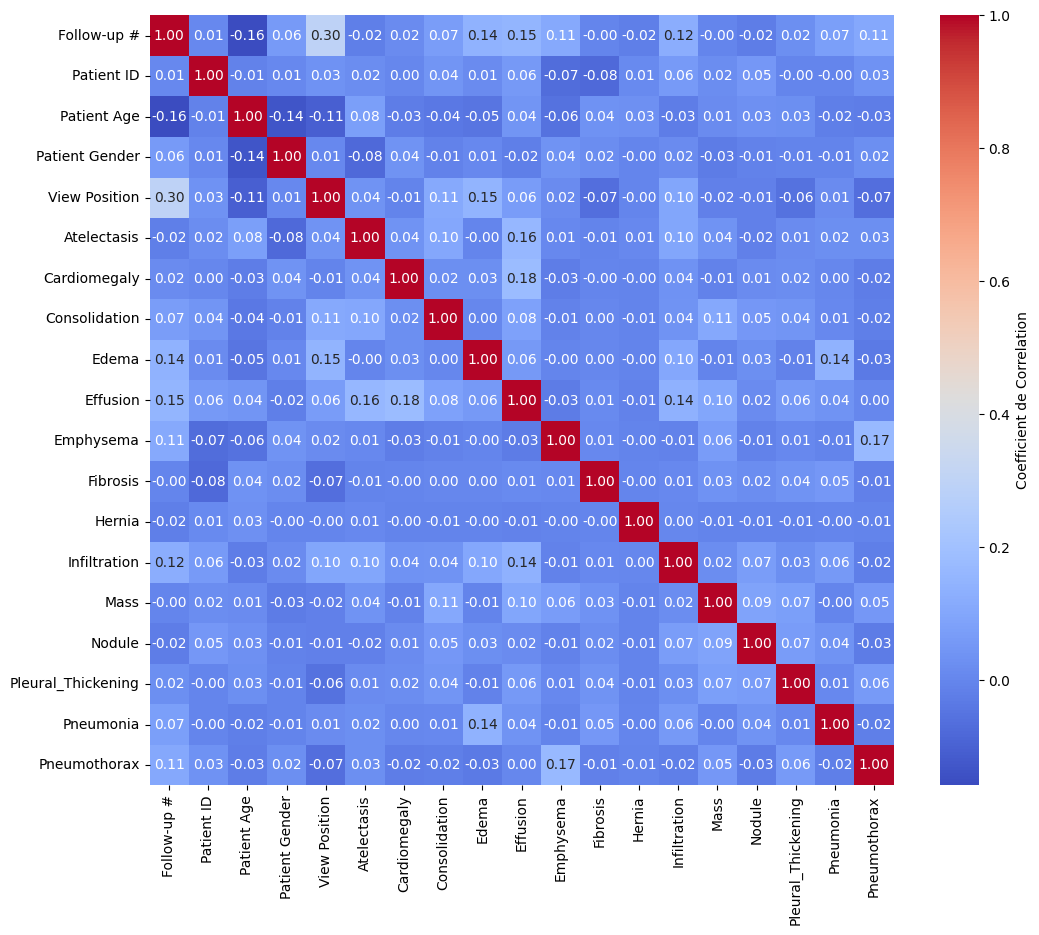

In [45]:
# Encodage des variables categoriques
data_corr = mydata.copy(deep=True)
data_corr = data_corr.drop(columns= ['No Finding', 'Image Index', 'WEIGHTS'])

correlation_matrix = data_corr.corr()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Coefficient de Correlation'})
plt.show()


# Analyse des coorelations

## - Follow Up:

On remarque quelles maladies ont besoin d'un nombre plus grande de radiographies: 
Dans l'ordre decroissant on a : Edema (0.16) , Infiltratioin (0.13) , Cardiomegaly et Pleural Thickening (0.12)

On a aussi un coefficient de 0.32 entre Follow-up et View position, ce qui peut indiquer que si le nombre de follow ups augmente on a un peu plus de tendance a avoir des radiographies AP

## - Patient Age:

Il n'y a pas des correlatioiins fortes entre l'age et les maladies dans ce dataset, la correlatiion la plus forte serait avec Hernia (0.22) qui impliquerait que les personnes ag√©es ont plus tendance a etre susceptibles.

## - Patient Gender:

Le genre n'a pas des correlations fortes entre les maladies

## - View Position
On voit quelques correlations faibles avec les maladies suivantes :
Consolidation, Edema, Infiltration et Pneuomonia

## - Maladies

On constate que la plupart des maladies ne sont pas correll√©es entre-elles, c'est a dire qu'elles ne se chevauchent pas dans le dataset (on n'a pas souvent deux maladies).

Cependant il y a quelques correlations remarquables:

Ceci n'est pas un avis medical, je ne suis pas medecin et c'est le resultat d'une recherche rapide sur google

- **Cardiomegaly et Effusion (0.13)**:
    Cardiomegaly correspond a un coeur elargi et l'effusion correspond a l'accumulation de fluides, qui pourrait enlargir le coeur

- **Edema et Pneumonia (0.28)**:
    Pneumonia est une maladie qui provoque l'accumulation des fluides dans les poumons, et Edema est une autre maladie qui fait reference a l'acumulation des fluides

- **Emphysema et Pneumothorax (0.24)**:
    Pneumothorax correspond a  l'effondrement des poumons, certaines variations d'Emphysema peuvent provoquer ces effondrements.

Il faut rappeller aussi que ces correlations sont faibles ( < 0.3), et leur utilit√© pour le modele n'est pas forcement claire. 

# Pre-traitement des donn√©es:

Afin de re-equilibrer les maladies j'ai cr√©e deux approches differents, un a travers du resampling et un autre avec du reweighting

## Resampling:
    Le resampling consiste a soit effacer ou generer/dupliquer des donn√©es pour reequilibrer la quantite d'apparitions entre maladies, a la base je voulais utiliser SMOTE pour generer des donn√©es plus pertinentes mais ceci c'est aver√© difficile a implementer:

    l'approche est donc la suivante, eliminer des entr√©es au hasard des conditions sur-represent√©es et effacer des entr√©es au hasard des conditions sur-represent√©es

### Avantages

- **Facile a utiliser** 

- **Efficace pour les classes d√©s√©quilibr√©es** : Permet de montrer davantage d‚Äôexemples de la classe minoritaire (sur-√©chantillonnage) ou de r√©duire l‚Äôimpact trop important de la classe majoritaire (sous-√©chantillonnage).  

- **Flexibilit√©** : Des m√©thodes comme SMOTE, ADASYN ou autres variations du sur-√©chantillonnage peuvent g√©n√©rer des exemples synth√©tiques pour la classe minoritaire, pr√©servant mieux la diversit√© des donn√©es qu‚Äôun simple duplicata. ( Ce n'est pas mon cas)


### Inconv√©nients

- **Sur-apprentissage possible (sur-√©chantillonnage)** : Dupliquer simplement les √©chantillons minoritaires peut amener le mod√®le √† trop m√©moriser ces exemples sp√©cifiques.  

- **Perte de donn√©es (sous-√©chantillonnage)** : Supprimer des √©chantillons de la classe majoritaire revient √† jeter potentiellement des informations pr√©cieuses, ce qui diminue la taille du jeu de donn√©es.  

- **Temps d‚Äôentra√Ænement plus long (sur-√©chantillonnage)** : L‚Äôaugmentation du nombre d‚Äôexemples peut accro√Ætre la charge de calcul durant l‚Äôentra√Ænement.

In [46]:


def resample_label_to_n_samples(data, label, n_samples, random_state=123):
    """
    Resample le dataset pour que le label aille exactement  n_samples.

    Parametres:
    - data: dataset a resample.
    - label: label a resample.
    - n_samples: nombre de samples attendus pour le label indiqu√©.
    - random_state: Graine random.
    
    Renvoie:
    - resampled_data: dataframe apres resample
    """

    df_positive = data[data[label] == 1]  
    df_negative = data[data[label] == 0]  

    if len(df_positive) < n_samples:
        df_positive_resampled = resample(df_positive,
                                         replace=True,         
                                         n_samples=n_samples,
                                         random_state=random_state)
    else:
        df_positive_resampled = resample(df_positive,
                                         replace=False,        
                                         n_samples=n_samples,
                                         random_state=random_state)

    resampled_data = pd.concat([df_negative, df_positive_resampled])
    resampled_data = resampled_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return resampled_data



''' 
L'id√©e ici est de rapprocher les apparitions de chaque condition de la moyenne,
on utilise le scaling factor pour dire a quel point on veut l'approcher a la moyenne
de plus on a le tableau overrepresented pour ajuster le scaling factor pour les classes qui
sont vraiment eloign√©es de la moyenne
'''

counts = list(maladies_with_counts.values())
average_count = np.mean(counts)
scaling_factor = 0.35
target_counts = {}
for label, current_count in maladies_with_counts.items():
    target_count = int(current_count + scaling_factor * (average_count - current_count))
    target_counts[label] = target_count
    #print(f"Label: {label}, Current count: {current_count}, Target count: {target_count}")


overrepresented = [ 'No Finding','Effusion', 'Atelectasis','Infiltration']
features_columns = ['Follow-up #', 'Patient Age', 'Patient Gender', 'View Position']
data_resampled = mydata.copy()

for label in maladies_with_counts.keys():
    #print(f"\label: {label}")
    if label in overrepresented:
        if label == 'No Finding':
            sf = 0.3
        else:
            sf = 0.6

        target_count = int(target_counts[label]*sf) 

    else:
        target_count = target_counts[label] 

    current_count = maladies_with_counts[label]
    #print(f"Current count: {current_count}, Target count: {target_count}")
    data_resampled = resample_label_to_n_samples(
        data=data_resampled,
        label=label,
        n_samples= target_count,
        random_state=123
    )
    
    # Mettre a jour les counts
    maladies_with_counts[label] = data_resampled[data_resampled[label] == 1].shape[0]
    


In [47]:


maladies = conditions_encoded.columns

maladie_counts = [data_resampled[maladie].sum() for maladie in maladies]

# Creation des subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=["Follow Up", "Age", "Gender", "View Position"])

# On ajoute 4 Subplots
fig.add_trace(go.Box(x=data_resampled['Follow-up #'], name='Follow ups'), row=1, col=1)
fig.add_trace(go.Box(x=data_resampled['Patient Age'], name='Age'), row=1, col=2)
fig.add_trace(go.Histogram(x=data_resampled['Patient Gender'], name='Gender'), row=2, col=1)
fig.add_trace(go.Histogram(x=data_resampled['View Position'], name='View Position'), row=2, col=2)

#Barplot sur les images par maladie
fig2 = go.Figure(
    data = [go.Bar ( x = maladies, y = maladie_counts, text = maladie_counts, textposition='auto' )],
    layout_title_text = "Nombre d'images par maladie",
)


fig.update_layout(title="Plots des donn√©es")
fig.show()
fig2.show()

## Reweighting 
Le reweighting consiste a rajouter a chaque condition un poids correspondant a sa representatoion dans le dataset, Ici on utilise 3 methodes differentes:

Objectif : Accorder plus d'importance aux classes minoritaires pour am√©liorer l'apprentissage du mod√®le.



### Avantages

- **Pas de copie ou de suppression de donn√©es** : Pr√©serve la totalit√© des donn√©es initiales, √©vitant ainsi les probl√®mes li√©s √† la suppression (sous-√©chantillonnage) ou √† la duplication (sur-√©chantillonnage).  

- **Facile √† mettre en place dans de nombreux algorithmes** : De nombreuses biblioth√®ques de machine learning proposent des param√®tres pour sp√©cifier les poids des classes (par exemple, `class_weight` dans scikit-learn).  

- **Moins de risque de sur-apprentissage** : √âtant donn√© que les points de donn√©es ne sont pas dupliqu√©s, il y a moins de risques de m√©morisation excessive des exemples de la classe minoritaire.


### Inconv√©nients

- **Compatibilit√© limit√©e** : Tous les mod√®les ou librairies ne prennent pas n√©cessairement en charge la gestion de poids, surtout dans les solutions plus anciennes ou sp√©cialis√©es.  

- **Instabilit√© num√©rique possible** : Des poids trop grands ou trop petits peuvent rendre l‚Äôentra√Ænement et l‚Äôoptimisation plus instables, en particulier dans les r√©seaux de neurones.  

In [48]:


# D√©finir les tranches d'√¢ge (0-9, 10-19, ..., 90-99, 100+)
bins = list(range(0, 101, 10))  
age_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
mydata['Age Group'] = pd.cut(mydata['Patient Age'], bins=bins, labels=age_labels, right=False)


#Ceci est utilis√© dans les 3 methodes
gender_counts = mydata['Patient Gender'].value_counts()
vp_counts = mydata['View Position'].value_counts()
age_counts = mydata['Age Group'].value_counts()

# Median Frequency Balancing
Formule:

$$w_i = \frac{\text{fr√©quence m√©diane}}{\text{freq}(i)}$$

o√π la fr√©quence m√©diane est la m√©diane des fr√©quences de toutes les classes.

### Avantages :

Moins extr√™me que la fr√©quence inverse (√©vite les poids trop √©lev√©s).

Assure qu‚Äôaucune classe ne re√ßoit un poids excessivement bas.

Fonctionne bien pour des jeux de donn√©es avec un d√©s√©quilibre mod√©r√©.

### Inconv√©nients :

Ne g√®re pas bien les classes tr√®s rares (car d√©pend de la m√©diane).

Moins efficace que ENS pour les distributions tr√®s d√©s√©quilibr√©es.

### Meilleurs cas d‚Äôutilisation :

Classification multi-classes avec un d√©s√©quilibre mod√©r√©.

Donn√©es m√©dicales et biologiques, o√π certaines classes sont naturellement sous-repr√©sent√©es.

In [49]:
#MFB Gender, View Position, Age

median_frequency_pg = np.median(gender_counts.values)
median_frequency_vp = np.median(vp_counts.values)
median_frequency_age = np.median(age_counts.values)

weights_pg = gender_counts.apply(lambda freq: median_frequency_pg / freq)
weights_vp = vp_counts.apply(lambda freq: median_frequency_vp / freq)
weights_age = age_counts.apply(lambda freq: median_frequency_age / freq)


# Normalisation des poids (normalisation par la somme des poids)
total_weight_pg = weights_pg.sum()
total_weight_vp = weights_vp.sum()
total_weight_age = weights_age.sum()

# Normalisation
normalized_weights_pg = weights_pg / total_weight_pg
normalized_weights_vp = weights_vp / total_weight_vp
normalized_weights_age = weights_age / total_weight_age

# Appliquer les poids normalis√©s
mydata['Gender_MFB_weight'] = mydata['Patient Gender'].map(normalized_weights_pg)
mydata['VP_MFB_weight'] = mydata['View Position'].map(normalized_weights_vp)
mydata['Age_MFB_weight'] = mydata['Age Group'].map(normalized_weights_age)




# Effective Number of Samples
Formule :

$$w_i = \frac{1 - \beta^{n_i}}{1 - \beta}$$

o√π :

$n_i$‚Äã = nombre d‚Äô√©chantillons dans la classe ,

$\beta$ = facteur de lissage (typiquement 0,99 ou 0,999).

### Avantages :

Ajuste les poids de mani√®re progressive, √©vitant les valeurs extr√™mes.

Contr√¥le la pond√©ration des classes rares gr√¢ce au param√®tre Œ≤.

Fonctionne bien lorsque la distribution des classes est fortement d√©s√©quilibr√©e.


### Inconv√©nients :

N√©cessite de r√©gler l‚Äôhyperparam√®tre Œ≤.

Plus complexe √† calculer que la fr√©quence inverse.

### Meilleurs cas d‚Äôutilisation :

Probl√®mes de classification avec une distribution tr√®s d√©s√©quilibr√©e (ex. imagerie m√©dicale, vision par ordinateur, NLP).

Donn√©es hi√©rarchiques, o√π certaines cat√©gories apparaissent naturellement moins souvent.

In [50]:
#ENS Gender
beta = 0.9999


# Calcul des poids EN
def calculate_en_weight(count, beta):
    return (1 - beta) / (1 - beta ** count)

# Number of  samples

gender_weights = {gender: calculate_en_weight(count, beta) for gender, count in gender_counts.items()}
vp_weights = {vp: calculate_en_weight(count, beta) for vp, count in vp_counts.items()}
age_weights = {age_group: calculate_en_weight(count, beta) for age_group, count in age_counts.items()}


#Normalisation
total_weight_gender = sum(gender_weights.values())
normalized_gender_weights = {gender: weight / total_weight_gender for gender, weight in gender_weights.items()}

total_weight_vp = sum(vp_weights.values())
normalized_vp_weights = {vp: weight / total_weight_vp for vp, weight in vp_weights.items()}

total_weight_age = sum(age_weights.values())
normalized_age_weights = {age_group: weight / total_weight_age for age_group, weight in age_weights.items()}


#Appliquer au data Frame
mydata['Gender_ENS_weight'] = mydata['Patient Gender'].map(normalized_gender_weights)
mydata['VP_ENS_weight'] = mydata['View Position'].map(normalized_vp_weights)
mydata['Age_ENS_weight'] = mydata['Age Group'].map(normalized_age_weights)

# Inverse class frequency
Formule :
    $$w_i = 1 / freq(i)$$

o√π freq(i) est le nombre d‚Äôoccurrences de la classe i.

### Avantages :

Simple et facile √† mettre en ≈ìuvre.

Fonctionne bien lorsque les fr√©quences des classes sont tr√®s diff√©rentes.

Aide √† g√©rer des d√©s√©quilibres de classe importants.

### Inconv√©nients :
Peut conduire √† une surcompensation des classes rares, rendant l‚Äôentra√Ænement instable.

Les classes tr√®s minoritaires re√ßoivent des poids extr√™mement √©lev√©s, ce qui peut provoquer du surapprentissage.

Ne prend pas en compte la difficult√© d‚Äôapprentissage d‚Äôune classe.

### Meilleurs cas d‚Äôutilisation :

Classification binaire et multi-classes avec un fort d√©s√©quilibre des classes.

Situations o√π les classes sous-repr√©sent√©es doivent avoir plus d‚Äôimportance.

In [82]:
#ICF Gender
# Calcul des poids inverses bas√©s sur la fr√©quence
gender_weights = {gender: 1.0 / count for gender, count in gender_counts.items()}
vp_weights = {vp: 1.0 / count for vp, count in vp_counts.items()}
age_weights = {age_group: 1.0 / count for age_group, count in age_counts.items()}

# Normalisation
total_weight_gender = sum(gender_weights.values())
normalized_gender_weights = {gender: weight / total_weight_gender for gender, weight in gender_weights.items()}

total_weight_icf = sum(vp_weights.values())
normalized_vp_weights = {vp: weight / total_weight_icf for vp, weight in vp_weights.items()}

total_weight_age = sum(age_weights.values())
normalized_age_weights = {age_group: weight / total_weight_age for age_group, weight in age_weights.items()}

#Appliquer Poids
mydata['Gender_ICF_weight'] = mydata['Patient Gender'].map(normalized_gender_weights)
mydata['VP_ICF_weight'] = mydata['View Position'].map(normalized_vp_weights)
mydata['Age_ICF_weight'] = mydata['Age Group'].map(normalized_age_weights)



# Post-Processing

On cherche √† conna√Ætre √† quel point le modele incr√©mente les biais, on a pris 3 param√®tres importants:
- View Position
- Age (On a divis√©e en tranches de 10 ans)
- Gender

Puis on a calcul√© les poids avec les m√©thodes:
- Inverse class frequency
- Effective number of samples 
- Median Frequency balancing

On cherche donc √† analyser quelques metriques int√©ressantes. Pour √ßa, on utilisera: 
- Precision
- Recall
- F1 Score
pour chaque param√®tre afin de verifier s'il y a un biais et comment le modele reagit en fonction


In [179]:
suffix = ['Gender_', 'VP_','Age_']
methods = [ 'MFB', 'ENS', 'ICF']
fichiers = ['./expe_log/WEIGHTS.csv'] #On garde le poids par defaut pour voir les biais du modele:
datasets = {}

#On construit tous les chemins
for s in suffix:
    for m in methods:
        fichiers.append(f"./expe_log/{s}{m}_weight.csv")

#On transforme tout en valeurs numeriques
binary_mapping = {"malade": 1, "sain": 0}
age_mappings = {}
for i in range(0,len(age_labels)):
    age_mappings[age_labels[i]] = i

#On construit la liste des datasets
for fichier in fichiers:
    dataset = pd.read_csv(fichier)
    dataset.drop(columns=['Image Index'], inplace = True)
    dataset["preds"] = dataset["preds"].map(binary_mapping)
    dataset["labels"] = dataset["labels"].map(binary_mapping)
    dataset["Age Group"] = dataset["Age Group"].map(age_mappings)
    datasets[fichier] = dataset

In [192]:
privileged_groups = [{'Patient Gender': 0}]
unprivileged_groups = [{'Patient Gender': 1}]

aif_datasets = {}

for fichier, dataset in datasets.items():
    datasetf = StandardDataset(
        dataset,
        label_name='labels',               
        favorable_classes=[1],              
        protected_attribute_names=['Patient Gender','Age Group'], 
        privileged_classes=[[1]]       
    )
    aif_datasets[fichier] = datasetf

print(aif_datasets['./expe_log/Age_ENS_weight.csv'])


               instance weights    features                         \
                                                                     
                                Follow-up # Patient ID Patient Age   
instance names                                                       
0                           1.0         0.0        6.0        81.0   
1                           1.0         0.0       14.0        61.0   
2                           1.0         0.0       15.0        70.0   
3                           1.0         0.0       29.0        59.0   
4                           1.0         0.0       34.0        74.0   
...                         ...         ...        ...         ...   
5833                        1.0         0.0    30703.0        58.0   
5834                        1.0         1.0    30703.0        58.0   
5835                        1.0         0.0    30722.0        45.0   
5836                        1.0         0.0    30795.0        53.0   
5837                

In [ ]:
fichier = "./expe_log/WEIGHTS.csv"

base_rate = BinaryLabelDatasetMetric(aif_datasets[fichier], unprivileged_groups=[{"Patient Gender": 1}], privileged_groups=[{"Patient Gender": 0}]).base_rate()
print(f"{fichier.split('/')[-1].replace('.csv', '')}: {base_rate}")


consistency = BinaryLabelDatasetMetric(aif_datasets[fichier], unprivileged_groups=[{"Patient Gender": 1}], privileged_groups=[{"Patient Gender": 0}]).consistency()
print(f"{fichier.split('/')[-1].replace('.csv', '')}: {consistency}")

mean_difference = BinaryLabelDatasetMetric(aif_datasets[fichier], unprivileged_groups=[{"Patient Gender": 1}], privileged_groups=[{"Patient Gender": 0}]).mean_difference()
print(f"{fichier.split('/')[-1].replace('.csv', '')}: {mean_difference}")

md_output = ""



#CES METRIQUES SONT PEUT ETRE INUTILES
for age_group in range(10):

    base_rate = BinaryLabelDatasetMetric(aif_datasets[fichier], unprivileged_groups=[{"Age Group": age_group}], privileged_groups=[{"Age Group": age_group + 2}]).base_rate()
    md_output += f"### Base Rate for Age Group {age_group}: {base_rate}\n"
    
    consistency = BinaryLabelDatasetMetric(aif_datasets[fichier], unprivileged_groups=[{"Age Group": age_group}], privileged_groups=[{"Age Group": age_group + 1}]).consistency()
    md_output += f"**Consistency for Age Group {age_group}: {consistency}**\n\n"
    
  
    mean_difference = BinaryLabelDatasetMetric(aif_datasets[fichier], unprivileged_groups=[{"Age Group": age_group}], privileged_groups=[{"Age Group": age_group + 1}]).mean_difference()
    md_output += f"**Mean Difference for Age Group {age_group}: {mean_difference}**\n\n"

# Display the output
display(Markdown(md_output))

WEIGHTS: 0.48184309695101063
WEIGHTS: [0.70006852]
WEIGHTS: -0.014052667062823598


c:\Users\barto\Code Repos\Fairness\Fenv\Lib\site-packages\aif360\metrics\binary_label_dataset_metric.py:105: RuntimeWarning:

invalid value encountered in scalar divide



### Base Rate for Age Group 0: 0.48184309695101063
**Consistency for Age Group 0: [0.70006852]**

**Mean Difference for Age Group 0: -0.10843655059593366**

### Base Rate for Age Group 1: 0.48184309695101063
**Consistency for Age Group 1: [0.70006852]**

**Mean Difference for Age Group 1: 0.06505097065862958**

### Base Rate for Age Group 2: 0.48184309695101063
**Consistency for Age Group 2: [0.70006852]**

**Mean Difference for Age Group 2: 0.06332073065184712**

### Base Rate for Age Group 3: 0.48184309695101063
**Consistency for Age Group 3: [0.70006852]**

**Mean Difference for Age Group 3: 0.00799225460575198**

### Base Rate for Age Group 4: 0.48184309695101063
**Consistency for Age Group 4: [0.70006852]**

**Mean Difference for Age Group 4: -0.06031005535000389**

### Base Rate for Age Group 5: 0.48184309695101063
**Consistency for Age Group 5: [0.70006852]**

**Mean Difference for Age Group 5: -0.021437403790344922**

### Base Rate for Age Group 6: 0.48184309695101063
**Consistency for Age Group 6: [0.70006852]**

**Mean Difference for Age Group 6: 0.017181629272309318**

### Base Rate for Age Group 7: 0.48184309695101063
**Consistency for Age Group 7: [0.70006852]**

**Mean Difference for Age Group 7: -0.196316120906801**

### Base Rate for Age Group 8: 0.48184309695101063
**Consistency for Age Group 8: [0.70006852]**

**Mean Difference for Age Group 8: -0.1925**

### Base Rate for Age Group 9: 0.48184309695101063
**Consistency for Age Group 9: [0.70006852]**

**Mean Difference for Age Group 9: nan**



In [161]:
md_output = "## Disparate Impact Ratio en fonction du genre\n"

gender = list(datasets.items())[:4]
for fichier, df  in dict(gender).items():
    di_ratio = disparate_impact_ratio(
        y_true=df['labels'],
        y_pred=df['preds'], 
        prot_attr=df['Patient Gender'], 
        priv_group= 0,  
        pos_label=0        
    )
    
    md_output += f"**{fichier.split('/')[-1].replace('.csv', '')}**:  {di_ratio:.3f}%\n\n"

md_output += "## Disparate Impact Ratio en fonction de l'age\n"

age = list(datasets.items())[:1] + list(datasets.items())[-3:] 
for fichier, df in dict(age).items():
    privileged_group = 3
    di_ratio = disparate_impact_ratio(
        y_true=df['labels'],
        y_pred=df['preds'], 
        prot_attr=df['Age Group'],  
        priv_group=privileged_group,  
        pos_label=1        
    )
    
    md_output += f"**{fichier.split('/')[-1].replace('.csv', '')}**: {di_ratio:.3f}%\n\n"

md_output += "## Equal Opportunity Difference en fonction du genre\n"

gender = list(datasets.items())[:4]
for fichier, df  in dict(gender).items():
    eod = equal_opportunity_difference(
        y_true=df['labels'],
        y_pred=df['preds'], 
        prot_attr=df['Patient Gender'], 
        priv_group= 0,  
        pos_label=0        
    )
    
    md_output += f"**{fichier.split('/')[-1].replace('.csv', '')}**:  {eod:.3f}%\n\n"

md_output += "## Equal Opportunity Difference en fonction de l'age\n"

age = list(datasets.items())[:1] + list(datasets.items())[-3:] 
for fichier, df in dict(age).items():
    privileged_group = 8
    eod = equal_opportunity_difference(
        y_true=df['labels'],
        y_pred=df['preds'], 
        prot_attr=df['Age Group'],  
        priv_group=privileged_group,  
        pos_label=1      
    )
    
    md_output += f"**{fichier.split('/')[-1].replace('.csv', '')}**: {eod:.3f}%\n\n"

md_output += "## Average Odds Difference en fonction du genre\n"

gender = list(datasets.items())[:4]
for fichier, df  in dict(gender).items():
    aod = average_odds_difference(
        y_true=df['labels'],
        y_pred=df['preds'], 
        prot_attr=df['Patient Gender'], 
        priv_group= 0,  
        pos_label=0        
    )
    
    md_output += f"**{fichier.split('/')[-1].replace('.csv', '')}**:  {aod:.3f}%\n\n"

md_output += "## Average Odds Difference en fonction de l'age\n"

age = list(datasets.items())[:1] + list(datasets.items())[-3:] 
for fichier, df in dict(age).items():
    privileged_group = 8
    aod = average_odds_difference(
        y_true=df['labels'],
        y_pred=df['preds'], 
        prot_attr=df['Age Group'],  
        priv_group=privileged_group,  
        pos_label=1      
    )
    
    md_output += f"**{fichier.split('/')[-1].replace('.csv', '')}**: {aod:.3f}%\n\n"



display(Markdown(md_output))

## Disparate Impact Ratio en fonction du genre
**WEIGHTS**:  0.920%

**Gender_MFB_weight**:  0.959%

**Gender_ENS_weight**:  1.337%

**Gender_ICF_weight**:  0.877%

## Disparate Impact Ratio en fonction de l'age
**WEIGHTS**: 1.101%

**Age_MFB_weight**: 1.104%

**Age_ENS_weight**: 1.109%

**Age_ICF_weight**: 1.069%

## Equal Opportunity Difference en fonction du genre
**WEIGHTS**:  -0.059%

**Gender_MFB_weight**:  -0.020%

**Gender_ENS_weight**:  0.150%

**Gender_ICF_weight**:  -0.075%

## Equal Opportunity Difference en fonction de l'age
**WEIGHTS**: -0.214%

**Age_MFB_weight**: -0.219%

**Age_ENS_weight**: -0.235%

**Age_ICF_weight**: -0.521%

## Average Odds Difference en fonction du genre
**WEIGHTS**:  -0.043%

**Gender_MFB_weight**:  -0.027%

**Gender_ENS_weight**:  0.136%

**Gender_ICF_weight**:  -0.067%

## Average Odds Difference en fonction de l'age
**WEIGHTS**: -0.307%

**Age_MFB_weight**: -0.105%

**Age_ENS_weight**: -0.275%

**Age_ICF_weight**: -0.387%



### EXPLICACION DE YODA, CAMBIAR

Fairness Metrics Recap: How They Work and What They Measure

When evaluating fairness in machine learning, especially in sensitive domains like medical diagnosis using X-rays, it is important to ensure that the model does not disproportionately benefit or harm certain groups. Below is a recap of three key fairness metrics:
1Ô∏è‚É£ Disparate Impact Ratio (DI)

üîπ What it Measures:

    DI compares the selection rates (how often a group is predicted as positive) between an unprivileged and privileged group.

    It is a measure of demographic parity and checks whether a protected group is getting positive outcomes at the same rate as the privileged group.

üîπ Formula:
DI=P(Y^=1‚à£unprivileged group)P(Y^=1‚à£privileged group)
DI=P(Y^=1‚à£privileged group)P(Y^=1‚à£unprivileged group)‚Äã

Where:

    P(Y^=1)P(Y^=1) is the probability of being classified as positive.

üîπ Interpretation:
‚úÖ DI = 1 ‚Üí Perfect fairness (both groups have equal selection rates).
‚ö† DI < 1 ‚Üí Unprivileged group is disadvantaged (lower positive outcome rate).
‚ö† DI > 1 ‚Üí Privileged group is disadvantaged (higher positive outcome rate).

üîπ Example:

    If DI = 0.8, the unprivileged group has an 80% chance of receiving a positive outcome compared to the privileged group.

    If DI = 0.5, the unprivileged group is severely disadvantaged.

    Regulatory thresholds often consider DI below 0.8 as a sign of bias.

2Ô∏è‚É£ Equal Opportunity Difference (EOD)

üîπ What it Measures:

    EOD focuses on true positive rates (TPR) between unprivileged and privileged groups.

    It ensures equal recall across groups, meaning that both groups should have an equal chance of being correctly identified as positive.

üîπ Formula:
EOD=TPRunprivileged‚àíTPRprivileged
EOD=TPRunprivileged‚Äã‚àíTPRprivileged‚Äã

Where:

    TPR=TPTP+FNTPR=TP+FNTP‚Äã (True Positive Rate, also called recall).

üîπ Interpretation:
‚úÖ EOD = 0 ‚Üí Perfect fairness (both groups have equal recall).
‚ö† EOD > 0 ‚Üí Unprivileged group benefits (higher recall than privileged).
‚ö† EOD < 0 ‚Üí Privileged group benefits (higher recall than unprivileged).

üîπ Example:

    If EOD = -0.2, it means the privileged group has a 20% higher recall than the unprivileged group.

    This suggests that the model is missing more positive cases for the unprivileged group.

üîπ Why it Matters in Medical Context?

    In medical diagnosis, a negative EOD means the privileged group is getting diagnosed more accurately than the unprivileged group, leading to potential underdiagnosis in the unprivileged group.

3Ô∏è‚É£ Average Odds Difference (AOD)

üîπ What it Measures:

    AOD is a more comprehensive metric that looks at both TPR and False Positive Rate (FPR).

    It ensures that both detection rates and false alarm rates are fair across groups.

üîπ Formula:
AOD=(TPRunprivileged‚àíTPRprivileged)+(FPRunprivileged‚àíFPRprivileged)2
AOD=2(TPRunprivileged‚Äã‚àíTPRprivileged‚Äã)+(FPRunprivileged‚Äã‚àíFPRprivileged‚Äã)‚Äã

Where:

    FPR=FPFP+TNFPR=FP+TNFP‚Äã (False Positive Rate).

üîπ Interpretation:
‚úÖ AOD = 0 ‚Üí Perfect fairness (both groups have equal TPR and FPR).
‚ö† AOD > 0 ‚Üí Unprivileged group benefits (higher recall & lower false alarms).
‚ö† AOD < 0 ‚Üí Privileged group benefits (better recall & lower false alarms).

üîπ Example:

    If AOD = -0.15, the privileged group has a 15% advantage in detection and misclassification rates.

    If AOD = 0.05, the unprivileged group is slightly favored.

üîπ Why it Matters in Medical Context?

    A negative AOD means the model detects disease better for the privileged group and possibly misdiagnoses more cases in the unprivileged group.

    This can lead to worse health outcomes for the unprivileged group.

In [167]:
from sklearn.metrics import confusion_matrix

def calcul_tpr_fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    # flat le confusion matrix en array 1D
    tn, fp, fn, tp = cm.ravel()

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  

    return tpr, fpr

md_output = "### Calcul de TPR et FPR en fonction du genre \n"
md_output += "| Genre | TPR | FPR |\n"
md_output += "|-------|-----|-----|\n"  

for gender in [0, 1]:  # 0 pour hommes, 1 pour femmes
    df_gender = df[df['Patient Gender'] == gender]  # Filter by gender
    tpr_gender, fpr_gender = calcul_tpr_fpr(df_gender['labels'], df_gender['preds'])
    gender_label = "Hommes" if gender == 0 else "Femmes"
    # Add data to table with formatting to 4 decimal places
    md_output += f"| {gender_label} | {tpr_gender:.4f} | {fpr_gender:.4f} |\n"

md_output += "### Calcul de TPR et FPR en fonction de l'√¢ge \n"
md_output += "| Groupe d'Age | TPR | FPR |\n"
md_output += "|--------------|-----|-----|\n"  


for age_group in range(10):  
    df_age = df[df['Age Group'] == age_group]  # Filter by age group
    tpr_age, fpr_age = calcul_tpr_fpr(df_age['labels'], df_age['preds'])
    md_output += f"| {age_labels[age_group]} | {tpr_age:.4f} | {fpr_age:.4f} |\n"



display(Markdown(md_output))

### Calcul de TPR et FPR en fonction du genre 
| Genre | TPR | FPR |
|-------|-----|-----|
| Hommes | 0.4519 | 0.1653 |
| Femmes | 0.3699 | 0.1249 |
### Calcul de TPR et FPR en fonction de l'√¢ge 
| Groupe d'Age | TPR | FPR |
|--------------|-----|-----|
| 0-9 | 0.4857 | 0.0238 |
| 10-19 | 0.3470 | 0.1529 |
| 20-29 | 0.3823 | 0.1264 |
| 30-39 | 0.4529 | 0.1168 |
| 40-49 | 0.2906 | 0.1017 |
| 50-59 | 0.4013 | 0.1427 |
| 60-69 | 0.4608 | 0.2199 |
| 70-79 | 0.6103 | 0.2871 |
| 80-89 | 0.9318 | 0.4000 |
| 90-99 | 0.9545 | 0.0000 |


Le TPR (True Positive Rate) et le FPR (False Positive Rate) sont deux m√©triques importantes utilis√©es pour √©valuer la performance d'un mod√®le de classification, en particulier lorsqu'il s'agit de mesurer la qualit√© des pr√©dictions dans des contextes o√π les classes sont d√©s√©quilibr√©es ou lorsque l'on souhaite analyser les erreurs du mod√®le en fonction de sous-groupes.
1. True Positive Rate (TPR) ou Sensibilit√© / Rappel / Recall

Le TPR, √©galement appel√© rappel, mesure la capacit√© du mod√®le √† correctement identifier les exemples positifs parmi tous les exemples r√©ellement positifs.

La formule pour calculer le TPR est la suivante :
TPR=TPTP+FN
TPR=TP+FNTP‚Äã

O√π :

    TP (True Positives) : Nombre de vrais positifs (exemples correctement class√©s comme positifs).

    FN (False Negatives) : Nombre de faux n√©gatifs (exemples positifs mal class√©s comme n√©gatifs).

Interpr√©tation du TPR :

    Un TPR √©lev√© (proche de 1) signifie que le mod√®le identifie bien les exemples positifs, c'est-√†-dire qu'il a peu de faux n√©gatifs.

    Un TPR faible (proche de 0) signifie que le mod√®le manque une grande proportion des exemples positifs (beaucoup de faux n√©gatifs).

Exemple pour le genre :

Si le mod√®le pr√©dit correctement un grand nombre de femmes malades parmi toutes les femmes malades, le TPR pour les femmes sera √©lev√©. En revanche, si beaucoup de femmes malades sont mal class√©es comme n√©gatives, le TPR pour les femmes sera faible.
2. False Positive Rate (FPR) ou Taux de Faux Positifs

Le FPR mesure la proportion d'exemples n√©gatifs qui sont incorrectement class√©s comme positifs. Autrement dit, c'est la fraction d'exemples n√©gatifs qui sont mal class√©s comme positifs.

La formule pour calculer le FPR est la suivante :
FPR=FPFP+TN
FPR=FP+TNFP‚Äã

O√π :

    FP (False Positives) : Nombre de faux positifs (exemples n√©gatifs mal class√©s comme positifs).

    TN (True Negatives) : Nombre de vrais n√©gatifs (exemples correctement class√©s comme n√©gatifs).

Interpr√©tation du FPR :

    Un FPR faible (proche de 0) signifie que le mod√®le fait peu d'erreurs en classant des exemples n√©gatifs comme positifs (c'est-√†-dire qu'il a une faible proportion de faux positifs).

    Un FPR √©lev√© (proche de 1) signifie que le mod√®le classifie trop souvent des exemples n√©gatifs comme positifs (beaucoup de faux positifs).

Exemple pour l'√¢ge :

Si, pour un certain groupe d'√¢ge, le mod√®le pr√©dit √† tort que des patients non malades sont malades (faux positifs), le FPR pour ce groupe d'√¢ge sera √©lev√©. Si au contraire, il pr√©dit correctement un grand nombre de personnes non malades comme non malades, le FPR sera faible.
R√©sum√© de l'Interpr√©tation :

    TPR √©lev√© signifie que le mod√®le fait bien son travail pour d√©tecter les exemples positifs (peu de faux n√©gatifs).

    FPR faible signifie que le mod√®le fait peu d'erreurs en identifiant des exemples n√©gatifs comme positifs (peu de faux positifs).

TPR et FPR dans le Contexte des Sous-groupes :

Lorsque vous √©valuez le TPR et le FPR sur diff√©rents groupes de donn√©es (par exemple, sur le genre ou l'√¢ge), cela permet d'analyser l'√©quit√© du mod√®le pour chaque groupe :

    Si le TPR est significativement plus bas pour un groupe par rapport √† un autre, cela peut indiquer que le mod√®le a des difficult√©s √† d√©tecter les exemples positifs dans ce groupe.

    Si le FPR est plus √©lev√© pour un groupe, cela signifie que le mod√®le est plus susceptible de faire des erreurs en classifiant des exemples n√©gatifs comme positifs dans ce groupe.

En r√©sum√©, le TPR est une mesure de la capacit√© du mod√®le √† ne pas manquer des exemples positifs, tandis que le FPR est une mesure de la tendance du mod√®le √† identifier √† tort des exemples n√©gatifs comme positifs. Les deux m√©triques sont particuli√®rement utiles dans les analyses de biais et d'√©quit√©, car elles permettent de v√©rifier si le mod√®le se comporte de mani√®re √©quitable pour tous les groupes de donn√©es.
